# Aim

Let's try a multi-class classification problem, which is also common in the travel industry. Here's a problem scenario:

Flight Delay Category Prediction:
Predict the delay category of a flight (On-time, Short Delay, Medium Delay, Long Delay) based on various features.

Features could include:
1. departure_time (numeric - 24hr format)
2. day_of_week (categorical)
3. month (categorical)
4. airline (categorical)
5. route_distance (numeric)
6. aircraft_age (numeric)
7. weather_condition (categorical)
8. previous_delay (numeric)
9. passenger_load (numeric)
10. delay_category (target - 'on_time', 'short_delay', 'medium_delay', 'long_delay')

This problem introduces new challenges:
- Multi-class classification instead of binary
- Time-based features
- Multiple categorical variables
- Potential class imbalance
- Different evaluation metrics


# Import libraries

In [129]:
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, RobustScaler, label_binarize
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve, classification_report
from sklearn.decomposition import PCA

from imblearn import under_sampling, over_sampling
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

# Set seed

In [4]:
seed = 2025
random.seed(seed)
np.random.seed(seed)
# tf.random.set_seed(seed)

# Load data

In [5]:
n_samples = 1000

# Generate features
data = {
    'departure_time': np.random.randint(0, 2400, n_samples),  # 24hr format
    'day_of_week': np.random.choice(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], n_samples),
    'month': np.random.choice(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                             'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], n_samples),
    'airline': np.random.choice(['Airline_A', 'Airline_B', 'Airline_C', 'Airline_D'], n_samples),
    'route_distance': np.random.normal(1000, 500, n_samples),
    'aircraft_age': np.random.normal(8, 3, n_samples),
    'weather_condition': np.random.choice(['Clear', 'Rain', 'Snow', 'Fog'], n_samples),
    'previous_delay': np.random.normal(15, 10, n_samples),
    'passenger_load': np.random.uniform(0.5, 1.0, n_samples)
}

# Create delay categories based on features
delays = np.zeros(n_samples)
for i in range(n_samples):
    base_delay = 0
    # Weather impact
    if data['weather_condition'][i] == 'Snow':
        base_delay += np.random.normal(30, 10)
    elif data['weather_condition'][i] == 'Rain':
        base_delay += np.random.normal(15, 5)
    elif data['weather_condition'][i] == 'Fog':
        base_delay += np.random.normal(20, 7)
    
    # Previous delay impact
    base_delay += 0.3 * data['previous_delay'][i]
    
    # Distance impact
    base_delay += data['route_distance'][i] * 0.01
    
    # Add random noise
    base_delay += np.random.normal(0, 5)
    
    delays[i] = max(0, base_delay)

# Convert delays to categories
data['delay_category'] = pd.cut(delays, 
                               bins=[-np.inf, 15, 30, 60, np.inf],
                               labels=['on_time', 'short_delay', 'medium_delay', 'long_delay'])

df = pd.DataFrame(data)

# Add missing values (10%)
for column in df.columns:
    if column != 'delay_category':
        mask = np.random.random(len(df)) < 0.1
        df.loc[mask, column] = np.nan

# Add outliers (5%)
numeric_columns = ['route_distance', 'aircraft_age', 'previous_delay', 'passenger_load']
for column in numeric_columns:
    outlier_indices = np.random.choice(n_samples, size=int(n_samples * 0.05))
    df.loc[outlier_indices, column] = df[column].mean() + (df[column].std() * np.random.uniform(5, 10, size=len(outlier_indices)))

# Data preprocessing

## 1. Data analysis visualization

1. understand data types
2. missing
3. outliers
4. sample
5. target and input distribution
6. correlation matrix between feature or just general scatter

In [6]:
df.sample(5)

,departure_time,day_of_week,month,airline,route_distance,aircraft_age,weather_condition,previous_delay,passenger_load,delay_category
327,2028.0,Fri,Jul,NaN,1626.180873,8.746368,Clear,-1.150467,0.630963,short_delay
138,997.0,Tue,Sep,Airline_A,388.699098,7.324153,Fog,11.625914,1.959937,short_delay
654,2316.0,Wed,May,Airline_B,811.208249,11.134987,Fog,7.928116,0.563040,short_delay
14,1909.0,Mon,Apr,Airline_C,622.615522,6.871521,NaN,19.358441,0.573578,medium_delay
649,1000.0,Wed,May,Airline_C,2399.384806,6.258761,Fog,28.893564,0.813145,medium_delay


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   departure_time     894 non-null    float64 
 1   day_of_week        913 non-null    object  
 2   month              903 non-null    object  
 3   airline            895 non-null    object  
 4   route_distance     921 non-null    float64 
 5   aircraft_age       913 non-null    float64 
 6   weather_condition  886 non-null    object  
 7   previous_delay     905 non-null    float64 
 8   passenger_load     931 non-null    float64 
 9   delay_category     1000 non-null   category
dtypes: category(1), float64(5), object(4)
memory usage: 71.6+ KB


In [8]:
df.describe(include='all')

,departure_time,day_of_week,month,airline,route_distance,aircraft_age,weather_condition,previous_delay,passenger_load,delay_category
count,894.000000,913,903,895,921.000000,913.000000,886,905.000000,931.000000,1000
unique,NaN,7,12,4,NaN,NaN,4,NaN,NaN,4
top,NaN,Wed,Jan,Airline_B,NaN,NaN,Clear,NaN,NaN,medium_delay
freq,NaN,146,96,233,NaN,NaN,242,NaN,NaN,469
mean,1214.121924,NaN,NaN,NaN,1175.017704,9.440468,NaN,19.645727,0.816234,NaN
std,685.318441,NaN,NaN,NaN,979.508725,5.963962,NaN,20.846542,0.286410,NaN
min,2.000000,NaN,NaN,NaN,-567.830624,-1.674433,NaN,-15.696106,0.500011,NaN
25%,637.750000,NaN,NaN,NaN,677.634822,6.407162,NaN,9.081566,0.640668,NaN
50%,1228.500000,NaN,NaN,NaN,1009.489525,8.449147,NaN,16.090754,0.771364,NaN
75%,1805.500000,NaN,NaN,NaN,1358.554366,10.643829,NaN,22.854299,0.907625,NaN


/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


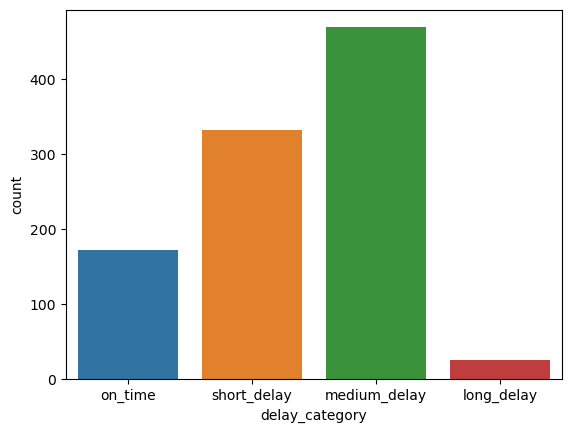

In [9]:
plt.figure()
sns.countplot(df, x='delay_category')
plt.show()

In [10]:
numeric_columns = ['route_distance', 'aircraft_age', 'previous_delay', 'passenger_load', 'departure_time']
nominal_columns = ['day_of_week', 'month', 'airline', 'weather_condition']

/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

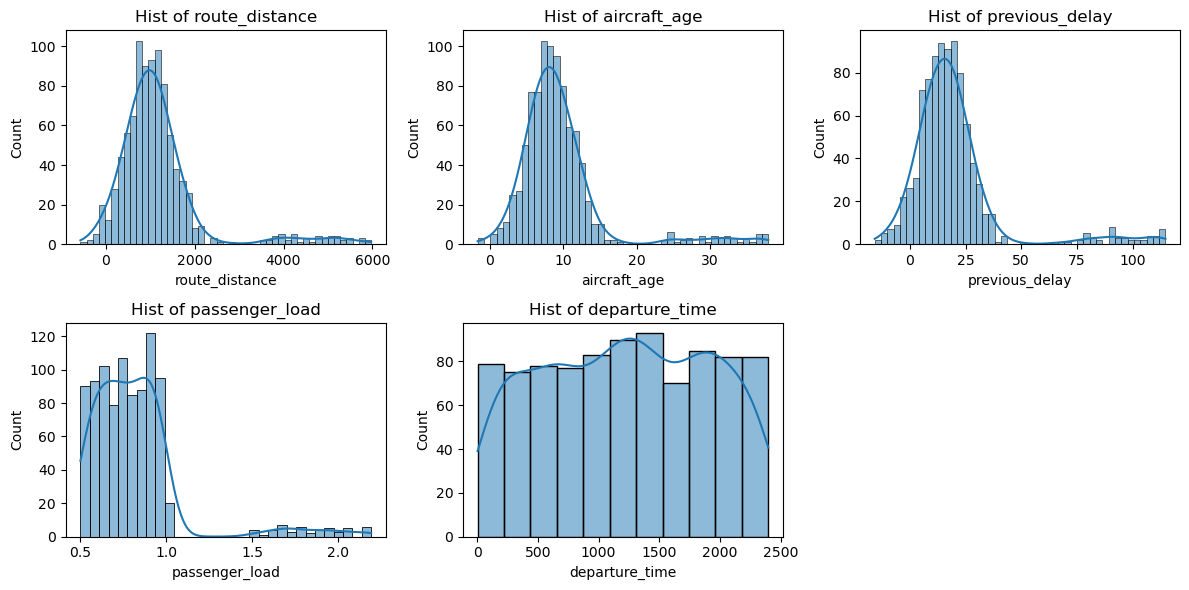

In [11]:
ncols = 3
nrows = (len(numeric_columns)//ncols)+1
plt.figure(figsize=(12,6))

for i,col in enumerate(numeric_columns,1):

    plt.subplot(nrows, ncols, i)
    sns.histplot(df[col], kde=True)
    plt.title(f'Hist of {col}')

plt.tight_layout()
plt.show()

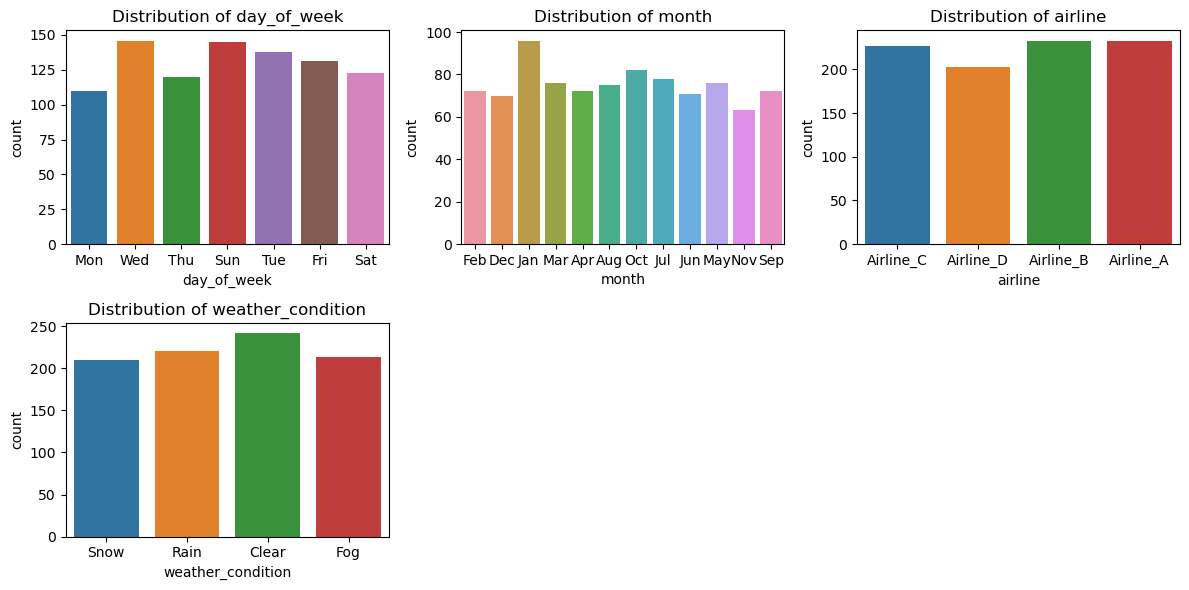

In [12]:
ncols = 3
nrows = (len(nominal_columns)//ncols)+1
plt.figure(figsize=(12,6))

for i,col in enumerate(nominal_columns,1):

    plt.subplot(nrows, ncols, i)
    sns.countplot(df, x=col)
    plt.title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

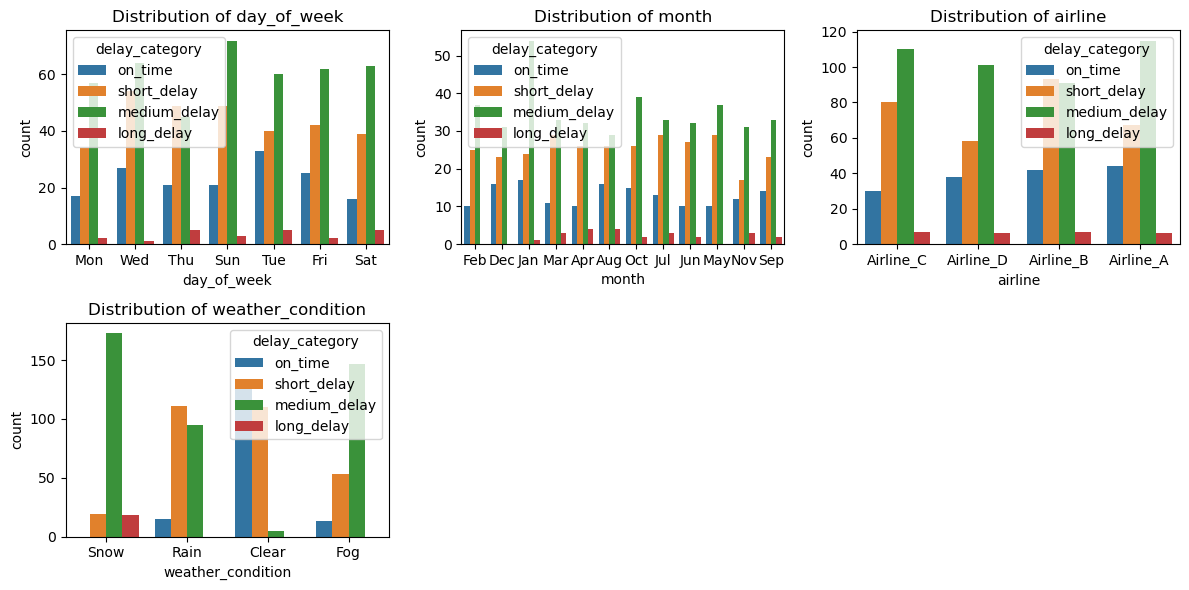

In [13]:
ncols = 3
nrows = (len(nominal_columns)//ncols)+1
plt.figure(figsize=(12,6))

for i,col in enumerate(nominal_columns,1):

    plt.subplot(nrows, ncols, i)
    sns.countplot(df, x=col, hue='delay_category')
    plt.title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

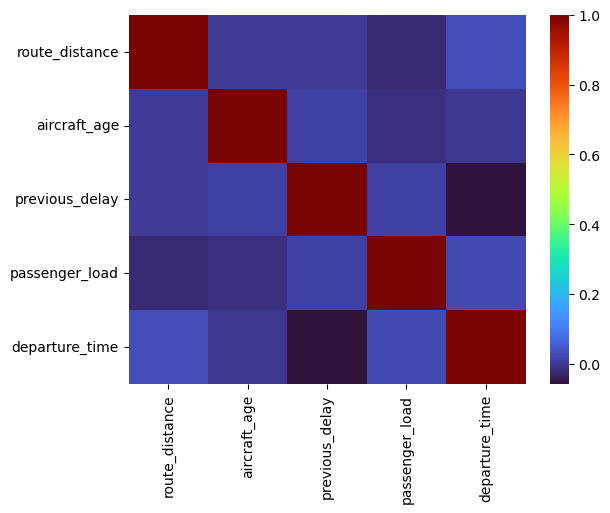

In [14]:
corr_matrix = df[numeric_columns].corr()
plt.figure()
sns.heatmap(corr_matrix, cmap='turbo')
plt.show()

## 2. Handle custom range

In [15]:
df['passenger_load'] = df['passenger_load'].clip(lower = 0, upper = 1)
df['departure_time'] = df['departure_time'].clip(lower = 0, upper = 2399)

## 3. Hande data types

In [16]:
# departure time
bins1 = [0, 400, 700, 1200, 1600, 1900, 2300, 2400]  
labels1 = ['Late Night', 'Early Morning', 'Morning', 'Afternoon', 'Evening', 'Night', 'Late Night']

df['departure_time_bin'] = pd.cut(df['departure_time'], bins=bins1, labels=labels1, right=False, ordered=False)

# previous delay
bins2 = [-np.inf, -5, 6, 16, 31, 61, np.inf]
labels2 = ['Before Time', 'No Delay', 'Short Delay', 'Moderate Delay', 'Long Delay', 'Severe Delay']
df['previous_delay_bin'] = pd.cut(df['previous_delay'], bins=bins2, labels=labels2, right= False, ordered=False)

In [17]:
nominal_columns = nominal_columns + ['departure_time_bin']
numeric_columns = [i for i in numeric_columns if i not in ('departure_time', 'previous_delay')]
ordinal_columns = ['previous_delay_bin']

## 4. Handle outliers

1. detect outliers visually and mathatmatically
2. handle outliers

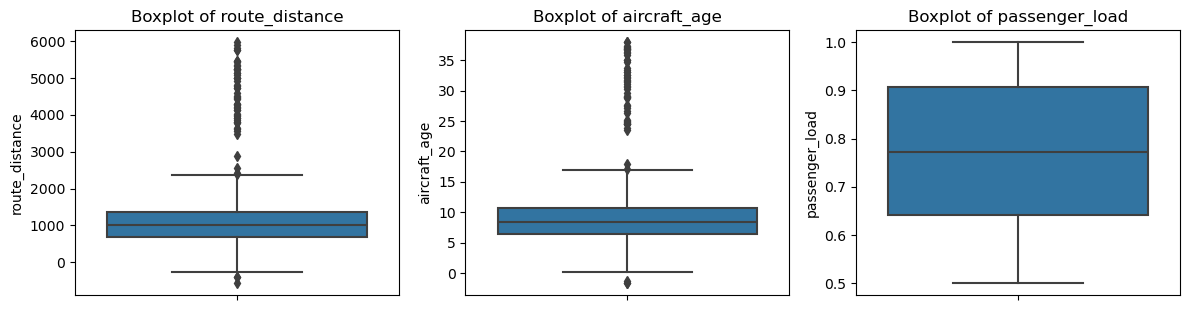

In [20]:
ncols = 3
nrows = (len(numeric_columns)//ncols)+1
plt.figure(figsize=(12,6))

for i,col in enumerate(numeric_columns,1):

    plt.subplot(nrows, ncols, i)
    sns.boxplot(data=df, y=col)
    plt.title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

In [21]:
df_no_outliers = df.copy(deep=True)

In [22]:
# error (drop, impute), errors but meaning (clipping), not an error (capping, transformation )
df_no_outliers['aircraft_age'] = np.log1p(df_no_outliers['aircraft_age'])
df_no_outliers['route_distance'] = np.log1p(df_no_outliers['route_distance'])

/opt/homebrew/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


## 5. Handle missing data

1. detect it
2. handle it
- mar, mcar, mnar
- type of column
- missing is important or not
- if target is missing

In [23]:
df_no_outliers.isna().sum()

departure_time        106
day_of_week            87
month                  97
airline               105
route_distance        107
aircraft_age           90
weather_condition     114
previous_delay         95
passenger_load         69
delay_category          0
departure_time_bin    106
previous_delay_bin     95
dtype: int64

In [24]:
df_no_missing = df_no_outliers.copy(deep=True)

In [25]:
# MCAR - departure_time_bin, day_of_week, month, airline, route_distance, weather_condition
# MAR - passenger_load, aircraft_age,
# MNAR -  previous_delay_bin

# MCAR
df_no_missing['departure_time_bin'] = df_no_missing['departure_time_bin'].fillna(df_no_missing['departure_time_bin'].mode()[0])
df_no_missing['day_of_week'] = df_no_missing['day_of_week'].fillna(df_no_missing['day_of_week'].mode()[0])
df_no_missing['month'] = df_no_missing['month'].fillna(df_no_missing['month'].mode()[0])
df_no_missing['airline'] = df_no_missing['airline'].fillna(df_no_missing['airline'].mode()[0])
df_no_missing['weather_condition'] = df_no_missing['weather_condition'].fillna(df_no_missing['weather_condition'].mode()[0])
df_no_missing['route_distance'] = df_no_missing['route_distance'].fillna(df_no_missing['route_distance'].median())

# MAR
df_no_missing['passenger_load'] = df_no_missing.groupby('airline')['passenger_load'].transform(lambda x: x.fillna(x.mean()))
df_no_missing['aircraft_age'] = df_no_missing.groupby('airline')['aircraft_age'].transform(lambda x: x.fillna(x.median()))

# MNAR
df_no_missing['previous_delay_missing'] = df_no_missing['previous_delay_bin'].isna().astype(int)
df_no_missing['previous_delay_bin'] = df_no_missing['previous_delay_bin'].cat.add_categories('Unknown')
df_no_missing['previous_delay_bin'] = df_no_missing['previous_delay_bin'].fillna('Unknown')

In [26]:
df_no_missing[numeric_columns+nominal_columns+ordinal_columns].isna().sum()

route_distance        0
aircraft_age          0
passenger_load        0
day_of_week           0
month                 0
airline               0
weather_condition     0
departure_time_bin    0
previous_delay_bin    0
dtype: int64

## 6. Handle noisy data

## 7. Feature engineering

In [27]:
df_no_missing['is_heavy_load'] = (df_no_missing['passenger_load'] > 0.85).astype(int)

In [28]:
nominal_columns = nominal_columns + ['previous_delay_missing', 'is_heavy_load']

## 8. Data transformation

1. numerical vs categorical

In [41]:
df_transform = df_no_missing.copy(deep=True)

In [42]:
# numerical columns
scaler = StandardScaler()
df_transform[['aircraft_age', 'route_distance']] = scaler.fit_transform(df_transform[['aircraft_age', 'route_distance']])

In [44]:
# nominal columns
onehot = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
encoded_df = pd.DataFrame(onehot.fit_transform(df_no_missing[nominal_columns]), columns=onehot.get_feature_names_out().tolist())

In [45]:
df_transform= df_transform.drop(columns=nominal_columns).reset_index(drop=True)
df_transform = pd.concat([df_transform, encoded_df], axis = 1)

In [46]:
df_transform.drop(['previous_delay', 'departure_time'], axis = 1, inplace = True)

In [48]:
ordinal_columns = ordinal_columns + ['delay_category']

In [47]:
# ordinal columns
ord = OrdinalEncoder(categories=[df_transform['previous_delay_bin'].unique().tolist(), df_transform['delay_category'].unique().tolist()])


In [49]:
df_transform[ordinal_columns]= ord.fit_transform(df_transform[ordinal_columns])

# Split

In [58]:
X = df_transform.drop(['delay_category'], axis = 1)
y = df_transform['delay_category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=seed, stratify=y)

# Class imbalance

In [59]:
y_train.value_counts()

delay_category
0.0    375
2.0    266
1.0    138
3.0     21
Name: count, dtype: int64

In [61]:
sampler = over_sampling.SMOTE(sampling_strategy='all',random_state=seed)
X_train_resample, y_train_resample = sampler.fit_resample(X_train, y_train)

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


# Feature analysis, importance and dimensionality reduction

In [64]:
tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(X_train_resample, y_train_resample)

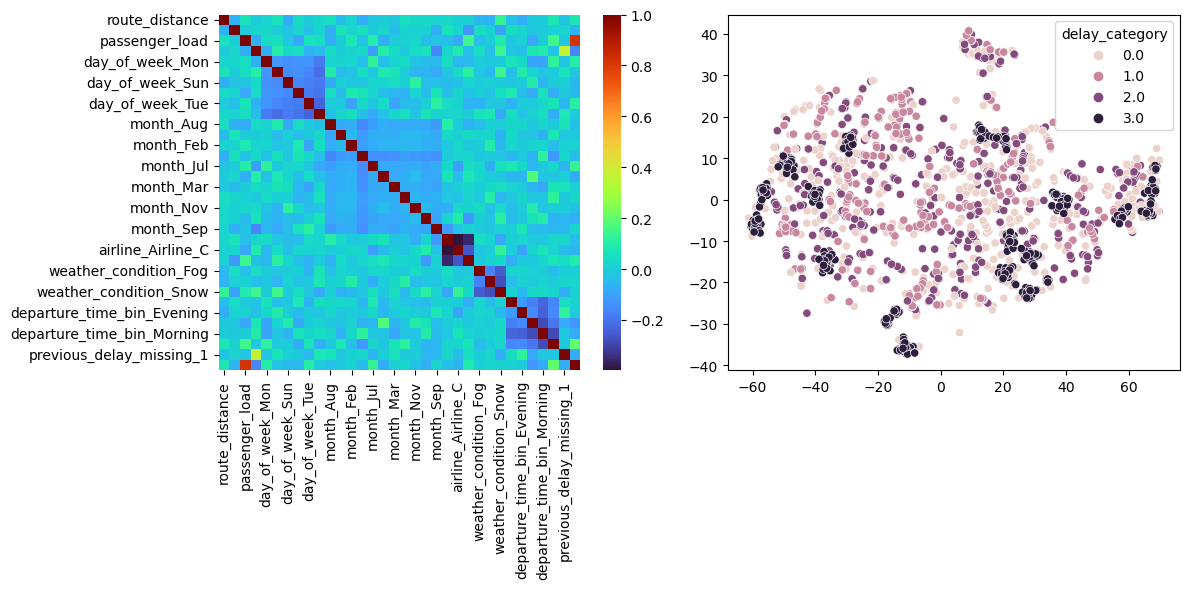

In [69]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
sns.heatmap(X_train_resample.corr(), cmap = 'turbo')

plt.subplot(1,2,2)
sns.scatterplot(x=tsne_result[:,0], y = tsne_result[:,1], hue = y_train_resample)
plt.tight_layout()
plt.show()

/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


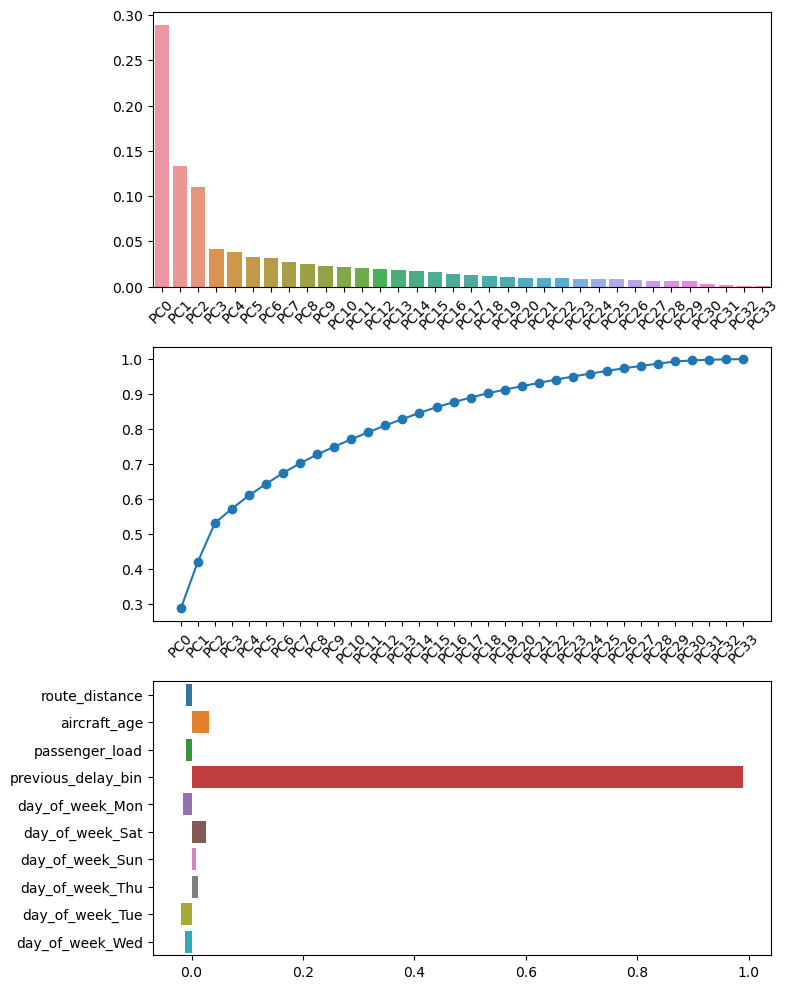

In [89]:
pca = PCA(n_components=X_train_resample.shape[1])
pca.fit(X_train_resample)
loading = pca.components_
explained_variance  = pca.explained_variance_ratio_


plt.figure(figsize=(8,10))

plt.subplot(3,1,1)
sns.barplot(x = [f'PC{i}' for i in range(pca.n_components_)], y = explained_variance)
plt.xticks(rotation = 45)

plt.subplot(3,1,2)
plt.plot([f'PC{i}' for i in range(pca.n_components_)],  np.cumsum(explained_variance), marker = 'o')
plt.xticks(rotation = 45)

plt.subplot(3,1,3)
sns.barplot(x = loading[0,:10], y = X_train_resample.columns[:10])

plt.tight_layout()
plt.show()

# Train model

In [98]:
model_logistic = LogisticRegression(max_iter=500)
model_logistic.fit(X_train_resample, y_train_resample)

LogisticRegression(max_iter=500)

In [130]:
model_forest = RandomForestClassifier(random_state=seed)
param_grid = {
    'n_estimators': [50,100,200],
    'min_samples_split' :[5,10], 
    'max_depth' : [None, 8,16,20]
}
grid = GridSearchCV(estimator=model_forest,cv=5, param_grid=param_grid)
grid.fit(X_train_resample, y_train_resample)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=2025),
             param_grid={'max_depth': [None, 8, 16, 20],
                         'min_samples_split': [5, 10],
                         'n_estimators': [50, 100, 200]})

In [105]:
#model_xgboost = XGBClassifier(random_state = seed, objective='multi:softmax', num_class=4)
#model_xgboost.fit(X_train_resample, y_train_resample)

In [137]:
best_forest_model = grid.best_estimator_

# Evaluate model

In [131]:
cv = KFold(shuffle=True, random_state=seed, n_splits=5)
scores = cross_val_score(estimator=model_logistic, X=X_train_resample, y=y_train_resample,cv=cv )

In [132]:
scores

array([0.62666667, 0.65333333, 0.62666667, 0.68333333, 0.67      ])

In [138]:
scores = cross_val_score(estimator=best_forest_model, X=X_train_resample, y=y_train_resample,cv=cv )

In [139]:
scores

array([0.81      , 0.79666667, 0.78666667, 0.85666667, 0.82      ])

# Test model

In [150]:
y_pred = model_logistic.predict(X_test)
y_pred = best_forest_model.predict(X_test)

In [151]:
y_test_bin=label_binarize(y_test, classes=[0,1,2,3])

In [152]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.71      0.71      0.71        94
         1.0       0.51      0.51      0.51        35
         2.0       0.51      0.55      0.53        66
         3.0       0.00      0.00      0.00         5

    accuracy                           0.60       200
   macro avg       0.43      0.44      0.44       200
weighted avg       0.59      0.60      0.60       200



/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [144]:
probs = best_forest_model.predict_proba(X_test)

In [145]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(4):

    fpr[i], tpr[i], _ =roc_curve(y_true=y_test_bin[:,i], y_score=probs[:,i])
    roc_auc[i] = roc_auc_score(y_true=y_test_bin[:,i], y_score=probs[:,i])

In [146]:
roc_auc

{0: 0.7868325973504617,
 1: 0.8453679653679653,
 2: 0.6855495251017639,
 3: 0.7348717948717949}

# Model deployment

# Model monitoring